In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
import time

import models
import flows

import neuraluq as neuq


data = sio.loadmat("./dataset/data_8.mat")
t = data["t"]
u_ref = data["sols"]
f = data["f"]
k = data["k"]

Backend is chosen to be the default, tensorflow. You can customize the backend by change it in the 'config.json' file, which can be created or found in your current directory.


In [2]:
l = 9999
u_exact = u_ref[:, 0, l:l+1]
f_exact = f[:, l:l+1]
k_exact = k[:, l:l+1]

j = 50
t_u_train = t[j:j+1, :]
u_train = u_exact[j:j+1, :]
t_f_train = t[::16]
f_train = f_exact[::16]

np.random.seed(666)
idx = np.random.choice(f_train.shape[0], f_train.shape[0], replace=False)[:8]
# idx = np.array([10, 11, 16,  7, 15,   8, 14,  0,  1])
f_train = f_train[idx]
t_f_train = t_f_train[idx]

In [3]:
# np.random.seed(3333)
noise_f = 0.05
noise_u = 0.005
f_train = f_train + noise_f * np.random.normal(size=f_train.shape)
u_train = u_train + noise_u * np.random.normal(size=u_train.shape)

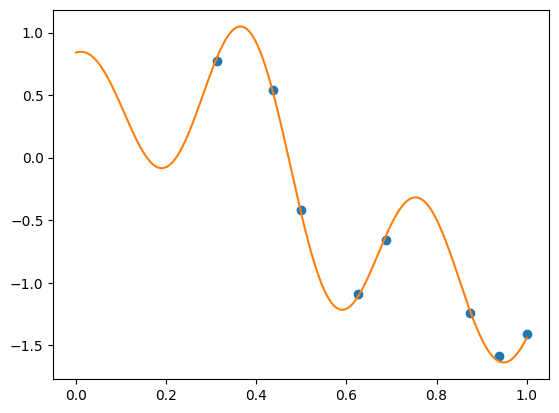

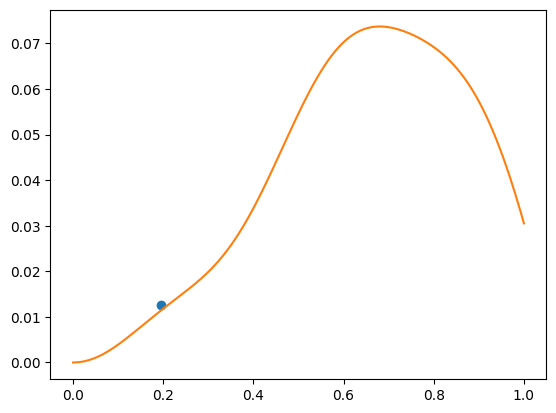

In [4]:
plt.plot(t_f_train, f_train, 'o')
plt.plot(t, f_exact)
plt.figure()
plt.plot(t_u_train, u_train, "o")
plt.plot(t, u_exact)

In [5]:
#### Load meta and nf
# meta = models.MHPINN(num_tasks=2000, dim=50, name="mhpinn")
meta = models.MHPINN(num_tasks=2000, dim=50, name="meta_KL_8")
meta.restore()

permutation = list(np.arange(26, 52, 1)) + list(np.arange(0, 26, 1))
nf = flows.MAF(
    dim=52,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf_KL_8",
)
nf.restore()

In [6]:
import hmc

In [7]:
def pde_fn(t, u, log_k):
    u_t = tf.gradients(u, t)[0]
    u_tt = tf.gradients(u_t, t)[0]
    k = tf.math.exp(log_k)
    f_pred = u_tt + k * tf.math.sin(u)
    return f_pred

In [8]:
model = hmc.PI_Bayesian(
    t_u=t_u_train, 
    u=u_train, 
    t_f=t_f_train, 
    f=f_train, 
    pde_fn=pde_fn, 
    meta=meta, 
    flow=nf,
    noise_u=noise_u,
    noise_f=noise_f,
)

In [9]:
model.initial_values.shape

TensorShape([1, 52])

In [10]:
log_posterior = model.build_posterior()
hmc_kernel = hmc.AdaptiveHMC(
    target_log_prob_fn=log_posterior,
    init_state=tf.zeros_like(model.initial_values),
    # init_state=model.initial_values,
    num_results=1000,
    num_burnin=1000,
    num_leapfrog_steps=30,
    step_size=0.01,
)

In [11]:
samples, results = hmc_kernel.run_chain()

(1, 52) (1, 51) (1, 1)
(1, 1) (8, 1)
(8, 1)


C:\Users\zouzo\anaconda3\envs\tf2\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


(1, 52) (1, 51) (1, 1)
(1, 1) (8, 1)
(8, 1)


In [12]:
print('Accepted rate: ', np.mean(results.inner_results.is_accepted.numpy()))

Accepted rate:  0.681


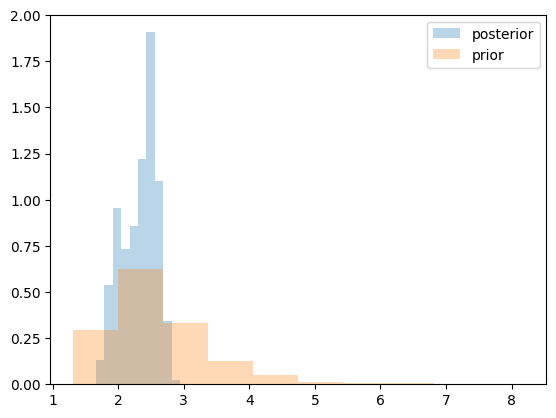

In [13]:
plt.figure(dpi=100)
plt.hist(tf.math.exp(samples[:, 0, -1]).numpy(), density=True, label="posterior", bins=10, alpha=0.3)
plt.hist(tf.math.exp(nf.sample(1000)[:, -1]).numpy().flatten(), density=True, label="prior", bins=10, alpha=0.3)
plt.legend()
plt.savefig("histogram2.png")
plt.show()

In [14]:
k_posterior = tf.math.exp(samples[:, 0, -1])
k_prior = tf.math.exp(nf.sample(1000)[:, -1]).numpy().flatten()

In [15]:
k_exact

array([[2.36091292]])

In [16]:
print(np.mean(tf.math.exp(samples[:, 0, -1]).numpy()))
print(np.std(tf.math.exp(samples[:, 0, -1]).numpy()))

2.3199034
0.26162568


In [17]:
t_test = tf.constant(t, tf.float32)
u_pred = model.meta.call(t_test, tf.transpose(samples[:, 0, :-1])).numpy()
mu_u = np.mean(u_pred, axis=-1)
std_u = np.std(u_pred, axis=-1)

f_pred = meta.pde(t_test, tf.transpose(samples[:, 0, :-1]), samples[:, 0, -1])
mu_f = np.mean(f_pred, axis=-1)
std_f = np.std(f_pred, axis=-1)

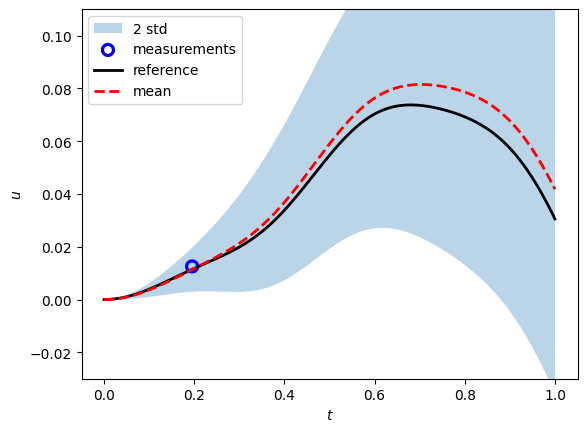

In [18]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
ax.fill_between(t_test.numpy().flatten(), (mu_u+2*std_u), (mu_u-2*std_u), alpha=0.3, label="2 std")
ax.scatter(t_u_train, u_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(t, u_exact, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(t, mu_u, color="red", linestyle="--", linewidth=2, label="mean")
ax.legend()
ax.set_ylabel("$u$")
ax.set_xlabel("$t$")
ax.set_ylim([-0.03, 0.11])
plt.show()
# plt.savefig("u_uq.png")

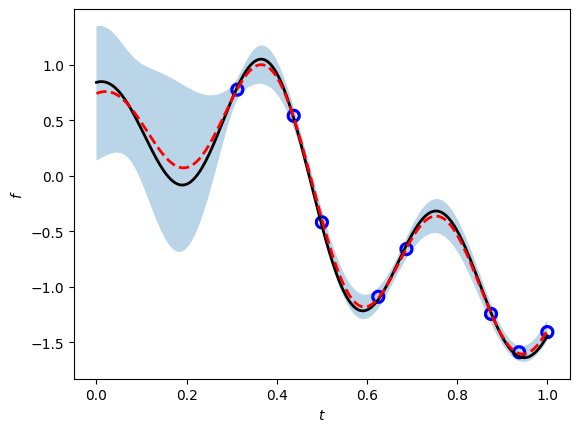

In [19]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
ax.fill_between(t_test.numpy().flatten(), (mu_f+2*std_f), (mu_f-2*std_f), alpha=0.3, label="2 std")
ax.scatter(t_f_train, f_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(t, f_exact, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(t, mu_f, color="red", linestyle="--", linewidth=2, label="mean")
# ax.legend()
ax.set_ylabel("$f$")
ax.set_xlabel("$t$")
# ax.set_ylim([-1.7, 1.2])
# plt.savefig("f_uq.png")
plt.show()

In [20]:
sio.savemat(
    "hmc.mat",
    {
        "t": t_test.numpy(),
        "f_mu": mu_f, "u_mu": mu_u,
        "f_std": std_f, "u_std": std_u,
        "t_f_train": t_f_train,
        "f_train": f_train,
        "t_u_train": t_u_train,
        "u_train": u_train,
        "f_ref": f_exact,
        "u_ref": u_exact,
        "k_ref": k_exact.flatten(),
        "k_prior": k_prior.flatten(),
        "k_posterior": k_posterior.numpy().flatten()
    }
)

In [21]:
noise_u

0.005

In [22]:
noise_f

0.05